In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.animation as animation # animation

import imageio 
import os
import netCDF4 as nc
import matplotlib as mpl
import shapefile
import pyproj

import fiona
from shapely.geometry import shape
import rasterio
import rasterio.transform
import rasterio.mask
from fiona import Feature, Geometry
from shapely.geometry import mapping, shape
import os

from scipy.ndimage import binary_dilation

from rasterio.warp import reproject, Resampling
from rasterio.crs import CRS
from osgeo import gdal

In [2]:
common_years = np.arange(2005,2017,1)

selecao_path = '/Users/francesco/Desktop/Thesis/Data/dataset_filtered/selecao.txt' #CHANGE IN CLUSTER
ids_selecao = np.loadtxt(selecao_path, dtype=int)

In [3]:
#get information from the shp file, without creating the output tif files

shapefile_path = '/Users/francesco/Desktop//Thesis/Data/ice_shelf.shp'

ids = []
Names = []
boundaries = []

shapefile=fiona.open(shapefile_path)

for feature in shapefile:

    id = feature['properties']['id']
    name=feature['properties']['name']
    geometry=feature['geometry']
    if geometry is None:
        continue

    bounds=shape(geometry).bounds

    #I expand the boundaries of 5000 m (10 pixels)
    xmin=bounds[0]-5000;ymin=bounds[1]-5000;xmax=bounds[2]+5000;ymax=bounds[3]+5000

    #Condition for Twaithes
    if id == 56:
        xmin=bounds[0]-57000;ymin=bounds[1]-50000;xmax=bounds[2]+50000;ymax=bounds[3]+10000

    #Taking the info
    ids.append(id)
    Names.append(name)
    boundaries.append([xmin,xmax,ymin,ymax])

#create a dataset with the information retrived from the previous bloc
df = pd.DataFrame({ 'Names':Names, 'boundaries': boundaries}, index = ids)

# I want to sort this dataset according to the index
df = df.sort_index()
pd.set_option('display.max_rows', None)
#Select just selecao
df = df[np.isin(df.index, ids_selecao)]

In [4]:
#load the datasets
directory = '/Users/francesco/Desktop/Thesis/Thickness'

ice_mask = np.load(directory+'/ice_mask.npy', allow_pickle=True) #CHANGE IN CLUSTER
sea_mask = np.load(directory+'/sea_mask.npy', allow_pickle=True)
land_mask = np.load(directory+'/land_mask.npy', allow_pickle=True)
grounded_ice_mask = np.load(directory+'/grounded_ice_mask.npy', allow_pickle=True)
borders = np.load(directory+'/new_borders.npy', allow_pickle=True)

#crete the dataframes
ice_mask = pd.DataFrame(ice_mask, index = df.index, columns = common_years)
sea_mask = pd.DataFrame(sea_mask, index = df.index, columns = common_years)
land_mask = pd.DataFrame(land_mask, index = df.index, columns = common_years)
grounded_ice_mask = pd.DataFrame(grounded_ice_mask, index = df.index, columns = common_years)
borders = pd.DataFrame(borders, index = df.index, columns = common_years)

In [5]:
#Importing the basal melting tif and creating the file names

root = '/Users/francesco/Desktop/Thesis/Data/GEOTIFFs/melt_' #Change in cluster
end = '_warp_ps.tif'

file_names_bm = [] 

for year in common_years:
    file_names_bm.append(root+str(year)+end)

In [6]:
#Here i expand the sea mask of 10 pixels
sea_mask_expanded = sea_mask.copy()

for year in common_years:
    
        for id in df.index:
    
            sea_mask_tmp = sea_mask_expanded.loc[id, year]
            sea_mask_tmp = binary_dilation(sea_mask_tmp, iterations=15)
            sea_mask.loc[id, year] = sea_mask_tmp


In [7]:
# Calculating the average bm in the region of the ice shelf (30s)

bm_30_percentlie_average = pd.DataFrame(index = ids_selecao, columns = common_years)
problematic_regions = []

for file, year in zip(file_names_bm, common_years): 

    print('The year is ', str(year))
 
    for id in df.index:  # region

        xmin,xmax,ymin,ymax = df['boundaries'].loc[id]

        with rasterio.open(file, crs='EPSG:3031') as src:
        
            window = rasterio.windows.from_bounds(xmin,ymin,xmax,ymax,transform=src.transform)
            #N.B: Here i am selecting the 70th percentile, but I am actually taking the 30th percentile since the sign is invertite
            bm_30_percentlie_average.loc[id, year] = np.nanpercentile(src.read(1, window=window), 70)


The year is  2005
The year is  2006
The year is  2007
The year is  2008
The year is  2009
The year is  2010
The year is  2011
The year is  2012
The year is  2013
The year is  2014
The year is  2015
The year is  2016


In [8]:
#Here i will try to build up a dataframe with the boarders of the ice shelf
basal_melting = pd.DataFrame(index = ids_selecao, columns = common_years)

for file, year in zip(file_names_bm, common_years): 

    print('The year is ', str(year))
 
    for id in df.index:  # region

        xmin,xmax,ymin,ymax = df['boundaries'].loc[id]

        with rasterio.open(file, crs='EPSG:3031') as src:
        
            window = rasterio.windows.from_bounds(xmin,ymin,xmax,ymax,transform=src.transform)

            image = src.read(1, window=window)

            bm_tmp = np.where(borders.loc[id, year] == True, bm_30_percentlie_average.loc[id,year], image)

            basal_melting.loc[id, year] = bm_tmp


The year is  2005
The year is  2006
The year is  2007
The year is  2008
The year is  2009
The year is  2010
The year is  2011
The year is  2012
The year is  2013
The year is  2014
The year is  2015
The year is  2016


In [12]:
#Interpolation

import numpy as np
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import griddata

''' 
interpolated_values_cubic = pd.DataFrame(index = df.index, columns = common_years)


for id in df.index:
    print(id)
    for year in common_years:

        bm_nan_linear = np.where(np.isnan(basal_melting.loc[id,year]))
        bm_not_nan_linear = np.where(~np.isnan(basal_melting.loc[id,year]))

        bm_values = basal_melting.loc[id,year][bm_not_nan_linear]

        interpolated_values_cubic.loc[id,year] = griddata(
            bm_not_nan_linear, bm_values, bm_nan_linear, method='cubic')

#save the dataframe as numpy array

np.save(os.getcwd() + '/bm_just_interpolated_cubic.npy', interpolated_values_linear)

'''

" \ninterpolated_values_cubic = pd.DataFrame(index = df.index, columns = common_years)\n\n\nfor id in df.index:\n    print(id)\n    for year in common_years:\n\n        bm_nan_linear = np.where(np.isnan(basal_melting.loc[id,year]))\n        bm_not_nan_linear = np.where(~np.isnan(basal_melting.loc[id,year]))\n\n        bm_values = basal_melting.loc[id,year][bm_not_nan_linear]\n\n        interpolated_values_cubic.loc[id,year] = griddata(\n            bm_not_nan_linear, bm_values, bm_nan_linear, method='cubic')\n\n#save the dataframe as numpy array\n\nnp.save(os.getcwd() + '/bm_just_interpolated_cubic.npy', interpolated_values_linear)\n\n"

In [10]:
#load the dataframe
interpolated_values_cubic= np.load('/Users/francesco/Desktop/Thesis/exploration_basal_melting/bm_just_interpolated_cubic.npy', allow_pickle=True)

#Convert to a dataframe
interpolated_values_cubic = pd.DataFrame(interpolated_values_cubic, index = df.index, columns = common_years)

In [11]:
#Substitute the values where i interpolated

bm_interpolated_cubic = basal_melting.copy() #store the values where i interpolated

for id in df.index:
    for year in common_years:

        nan_indices = np.isnan(bm_interpolated_cubic.loc[id,year])

        bm_interpolated_cubic.loc[id,year][nan_indices] = interpolated_values_cubic.loc[id,year]
        bm_interpolated_cubic.loc[id,year] = np.where(ice_mask.loc[id,year] == True, bm_interpolated_cubic.loc[id,year], np.nan)


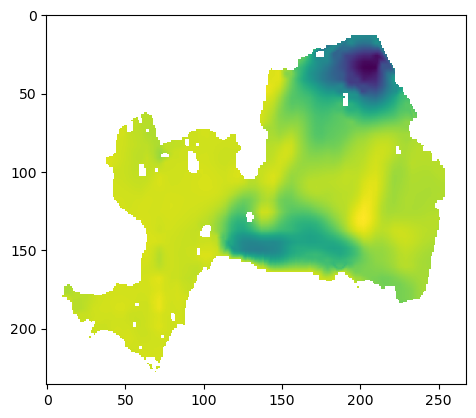

In [12]:
plt.imshow(bm_interpolated_cubic.loc[55,2005])

In [27]:
bm_30_percentlie_average.loc[55, 2005]

-3.7527063131332405

(236, 268)


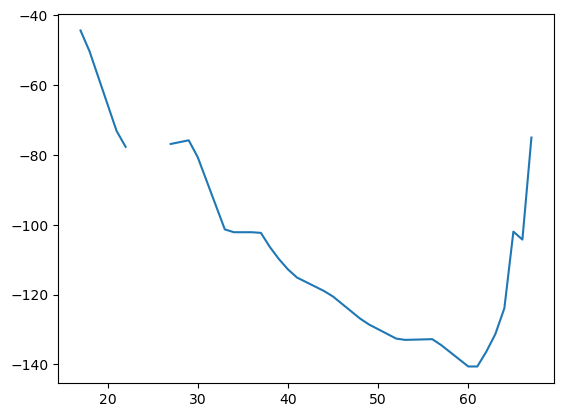

In [26]:
print(bm_interpolated_cubic.loc[55,2005].shape)
plt.plot(bm_interpolated_cubic.loc[55,2005][25,150:250])

In [24]:
#in the whole ice shelf count the number of values which are equals to the value bm_30_percentlie_average.loc[55,2005]
for i in range (0, 236):
    for j in range(0, 268):
        if bm_interpolated_cubic.loc[55,2005][i,j] == bm_30_percentlie_average.loc[55,2005]:
            print(i,j)

In [18]:
basal_melting_no_borders = pd.DataFrame(index = ids_selecao, columns = common_years)

for file, year in zip(file_names_bm, common_years): 

    print('The year is ', str(year))
 
    for id in df.index:  # region

        xmin,xmax,ymin,ymax = df['boundaries'].loc[id]

        with rasterio.open(file, crs='EPSG:3031') as src:
        
            window = rasterio.windows.from_bounds(xmin,ymin,xmax,ymax,transform=src.transform)

            image = src.read(1, window=window)

            basal_melting_no_borders.loc[id, year] = image

The year is  2005
The year is  2006
The year is  2007
The year is  2008
The year is  2009
The year is  2010
The year is  2011
The year is  2012
The year is  2013
The year is  2014
The year is  2015
The year is  2016


In [19]:

interpolated_mask = pd.DataFrame(index=df.index, columns=common_years)

for id in df.index:
    for year in common_years:
        # Check if the original mask is nan and the interpolated value is not nan
        interpolated_mask.loc[id, year] = np.isnan(basal_melting_no_borders.loc[id, year]) & ~np.isnan(bm_interpolated_cubic.loc[id, year])

#Save the mask of the interpolated values
#np.save(os.getcwd() + '/bm_interpolated_points.npy', interpolated_mask)

In [20]:
#load the dataset
interpolated_mask = np.load(os.getcwd() + '/bm_interpolated_points.npy', allow_pickle=True)

#Convert to a dataframe
interpolated_mask = pd.DataFrame(interpolated_mask, index = df.index, columns = common_years)

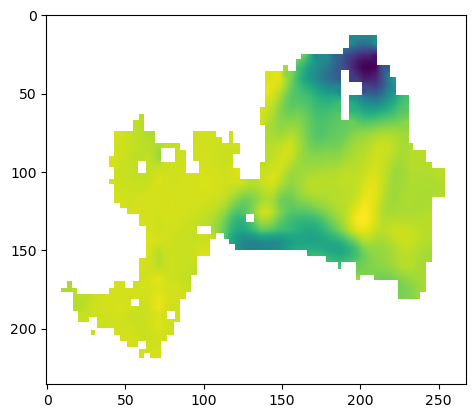

In [21]:
plt.imshow(basal_melting_no_borders.loc[55,2005])
#save the image
plt.savefig(os.getcwd() + '/ugo_55_2005.png')

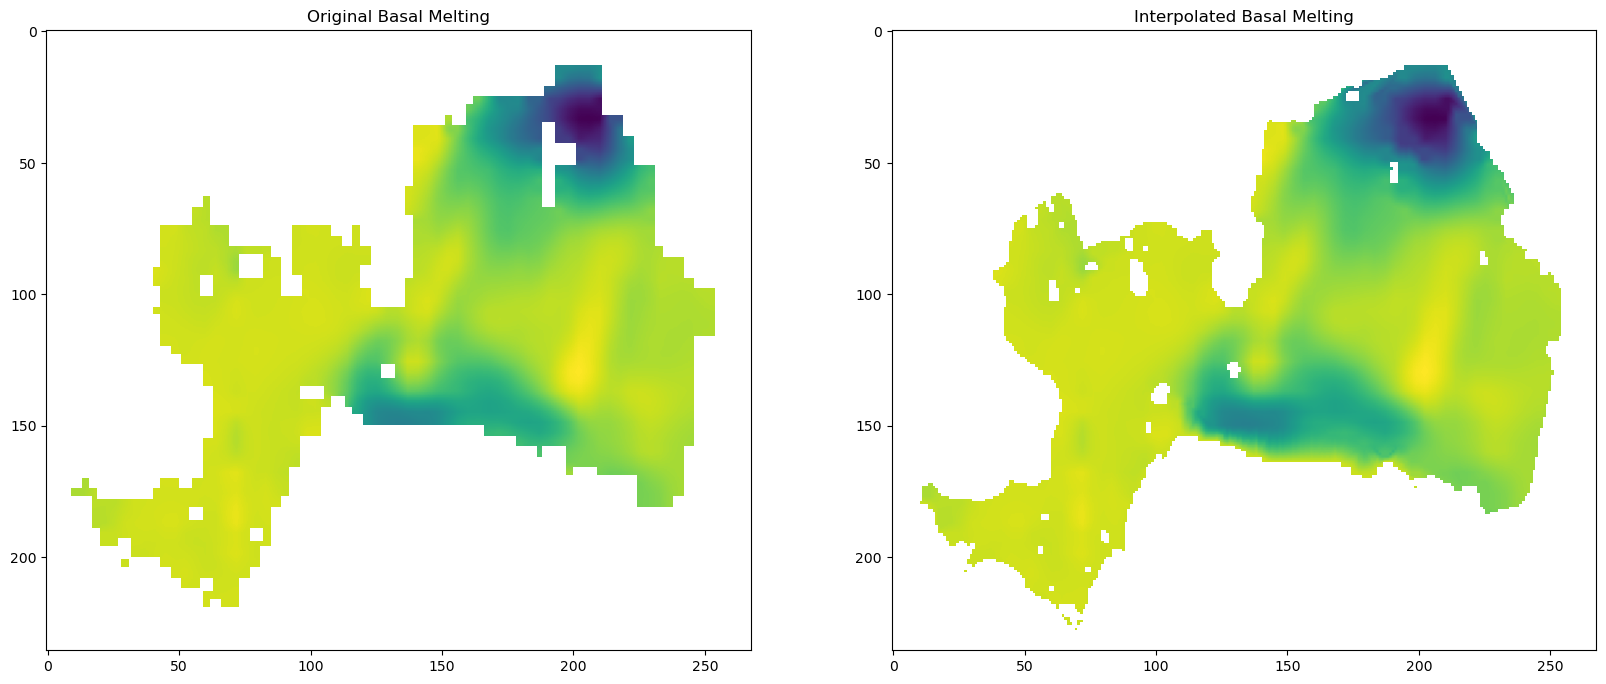

In [22]:
id = 55
year = 2005

#create 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

#plot the first subplot
ax1.imshow(basal_melting_no_borders.loc[id,year])
ax1.set_title('Original Basal Melting')

#plot the second subplot
ax2.imshow(bm_interpolated_cubic.loc[id,year])
ax2.set_title('Interpolated Basal Melting')

#save the immage
plt.savefig(os.getcwd() + '/ugo_DOPPIO_55_2005.png')


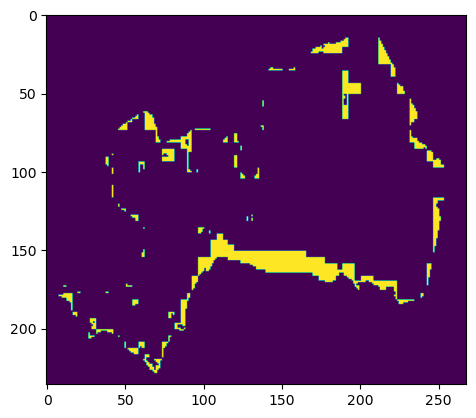

In [23]:
plt.imshow(interpolated_mask.loc[55,2005])

In [ ]:
#load the dataframe
interpolated_values_linear = np.load(os.getcwd() + '/bm_just_interpolated_cubic.npy', allow_pickle=True)
interpolated_values_linear = pd.DataFrame(interpolated_values_linear, index = df.index, columns = common_years)

From here on is just visualising

The year is  2005
The year is  2006
The year is  2007
The year is  2008
The year is  2009
The year is  2010
The year is  2011
The year is  2012
The year is  2013
The year is  2014
The year is  2015
The year is  2016
The year is  2005
The year is  2006
The year is  2007
The year is  2008
The year is  2009
The year is  2010
The year is  2011
The year is  2012
The year is  2013
The year is  2014
The year is  2015
The year is  2016


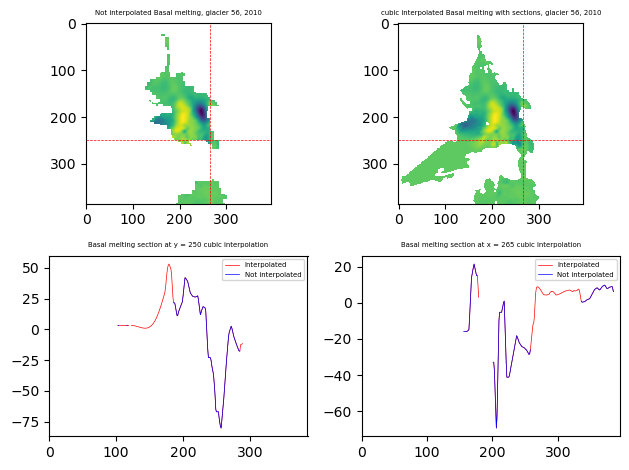

In [152]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import griddata


id = 56 
year = 2010
method = 'cubic'
line_y = 250
line_x = 265

# Create a 2x2 subplot layout
plt.subplot(2, 2, 1)

plt.imshow(basal_melting.loc[56, 2010], cmap='viridis')
plt.title('Not interpolated Basal melting, glacier ' +str(id) + ', ' + str(year), fontsize=5)
plt.axhline(y= line_y, color='red', linestyle='--', linewidth=0.5)
plt.axvline(x=line_x, color='red', linestyle='--', linewidth=0.5)


interpolated_values_linear = pd.DataFrame(index=df.index, columns=common_years)

bm_nan_linear = np.where(np.isnan(basal_melting.loc[id, 2010]))
bm_not_nan_linear = np.where(~np.isnan(basal_melting.loc[id, 2010]))

prova_linear = np.isnan(basal_melting.loc[id, 2010])  # Saves a mask where we have True for nan and False for not nan

bm_values = basal_melting.loc[id, 2010][bm_not_nan_linear]

interpolated_values_linear.loc[id, 2010] = griddata(
    bm_not_nan_linear, bm_values, bm_nan_linear, method= method)

bm_interpolated_linear = basal_melting.copy()

nan_indices = np.isnan(bm_interpolated_linear.loc[id, 2010])

bm_interpolated_linear.loc[id, 2010][nan_indices] = interpolated_values_linear.loc[id, 2010]
bm_interpolated_linear.loc[id, 2010] = np.where(ice_mask.loc[id, 2010] == True, bm_interpolated_linear.loc[id, 2010], np.nan)

plt.subplot(2, 2, 2,)  # Adjust figsize as needed
plt.imshow(bm_interpolated_linear.loc[id, 2010])
plt.axhline(y=line_y, color='red', linestyle='--', linewidth=0.5)
plt.axvline(x=line_x, color='red', linestyle='--', linewidth=0.5)
plt.title(method + ' interpolated Basal melting with sections, glacier ' +str(id) + ', ' + str(year), fontsize=5)

plt.subplot(2, 2, 3)
plt.plot(bm_interpolated_linear.loc[id, 2010][line_y], linewidth=0.5, color='red')

###Merdaccia
for file, year in zip(file_names_bm, common_years): 

    print('The year is ', str(year))
 
    for id in [56]:#df.index:  # region

        xmin,xmax,ymin,ymax = df['boundaries'].loc[id]

        with rasterio.open(file, crs='EPSG:3031') as src:
        
            window = rasterio.windows.from_bounds(xmin,ymin,xmax,ymax,transform=src.transform)

            image = src.read(1, window=window)

            bm_tmp = np.where(borders.loc[id, year] == True, bm_30_percentlie_average.loc[id,year], image)

            basal_melting.loc[id, year] = bm_tmp

#############################################

plt.plot(basal_melting.loc[id, 2010][line_y], linewidth=0.5, color='blue')
plt.title('Basal melting section at y = ' +str(line_y) + ' ' + method +' interpolation', fontsize=5) 
plt.xlim(0, np.shape(bm_interpolated_linear.loc[id, 2010])[0])

#Add legend
plt.legend(['Interpolated', 'Not interpolated'], loc='upper right', fontsize=5)





plt.subplot(2, 2, 4)
plt.plot(bm_interpolated_linear.loc[id, 2010][:, line_x], linewidth=0.5,color = 'red')

###Merdaccia
for file, year in zip(file_names_bm, common_years): 

    print('The year is ', str(year))
 
    for id in [id]:#df.index:  # region

        xmin,xmax,ymin,ymax = df['boundaries'].loc[id]

        with rasterio.open(file, crs='EPSG:3031') as src:
        
            window = rasterio.windows.from_bounds(xmin,ymin,xmax,ymax,transform=src.transform)

            image = src.read(1, window=window)

            bm_tmp = np.where(borders.loc[id, year] == True, bm_30_percentlie_average.loc[id,year], image)

            basal_melting.loc[id, year] = bm_tmp

plt.plot(basal_melting.loc[id, 2010][:, line_x], linewidth=0.5, color='blue')



plt.title('Basal melting section at x = ' +str(line_x) +  ' ' + method +' interpolation', fontsize=5) 
plt.xlim(0, np.shape(bm_interpolated_linear.loc[id, 2010])[1])
plt.legend(['Interpolated', 'Not interpolated'], loc='upper right', fontsize=5)

# Adjust layout for better spacing
plt.tight_layout()

# Save the plot taking into account tht is linear interpolation
plt.savefig('/Users/francesco/Desktop/' + method +'_interpolation.png', dpi=300, bbox_inches='tight')



Text(0.5, 1.0, 'Basal melting 2010, Twaites')

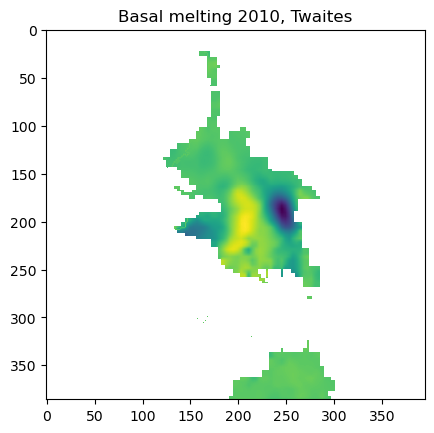

In [90]:
plt.imshow(basal_melting.loc[56, 2010])

plt.title('Basal melting 2010, Twaites')
#plt.plot(basal_melting.loc[55, 2010][145])

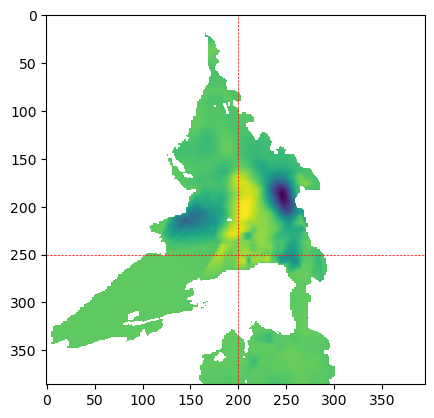

In [85]:
plt.imshow(bm_interpolated_linear.loc[id,2010])
plt.axhline(y=250, color='red', linestyle='--', linewidth=0.5)
plt.axvline(x=200, color='red', linestyle='--', linewidth=0.5)



#draw a line which shows the horizontal linne at y = 250


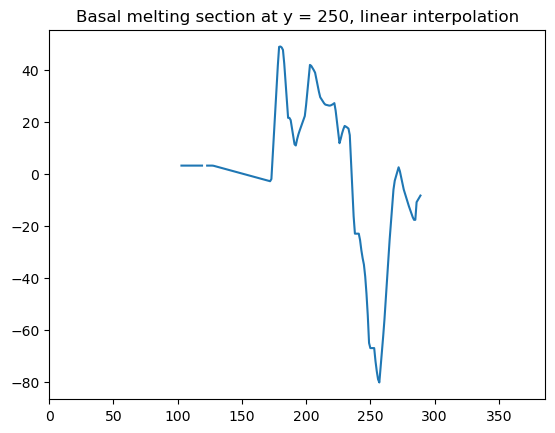

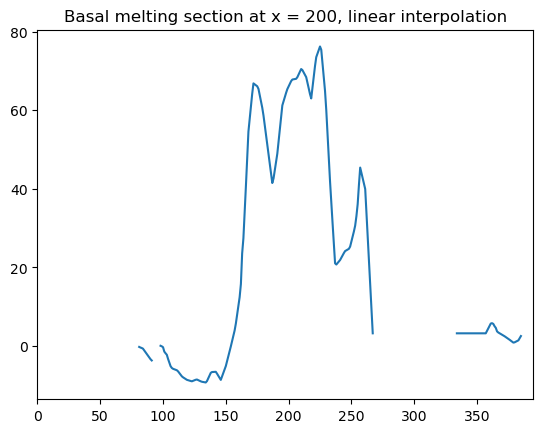

In [86]:
plt.plot(bm_interpolated_linear.loc[id,2010][250])
plt.title('Basal melting section at y = 250, linear interpolation')
plt.xlim(0,np.shape(bm_interpolated_linear.loc[id,2010])[0])
plt.show()


plt.plot(bm_interpolated_linear.loc[id,2010][:,200])
plt.title('Basal melting section at x = 200, linear interpolation')
plt.xlim(0,np.shape(bm_interpolated_linear.loc[id,2010])[1])
plt.show()

In [41]:
from scipy.interpolate import RegularGridInterpolator

#make an interpolationn with RegularGridInterpolator
id =  56

interpolated_values_regular_grid = RegularGridInterpolator(np.shape(basal_melting.loc[id,2010]), basal_melting.loc[id,2010],method= ''

type: too many indices for array: array is 0-dimensional, but 1 were indexed